# Using Tensorflow & Deep Learning to Classify the BreakHis Dataset

Generally, the steps we will be performing in this analysis are as follows:
- Importing the BreakHis images.
- Preprocessing the BreakHis images.
- Dividing the images to create a training set and testing set, then splitting the training set into 5 separate training/validation set pairs for 5-fold CV.
- Importing a pre-exisiting DNN architecture (VGG16, AlexNet, EfficientNet, etc.)
- Training the architecture on each of the training/validation set pairs.
- Using a set of metrics (accuracy, precision, recall, AUPRC, AUROC) to evaluate each of the models produced
- Determining the average value of each metric with respect to the validation sets used, then chosing the "best" model with these metrics
- Testing the best model on the reserved testing set to assess performance.

This will differ from previous analyses of the BreakHis dataset by:
- Utilizing cross validation (5-fold CV) as opposed to the less complex validation set approach.
- Using alternative architectures.
- Using more metrics for analysis of the trained models (ROC/AUROC).

Relevant links:
- [Keras documentation on transfer learning with VGG16](https://keras.io/guides/transfer_learning/)
- [Relevant Kaggle approach](https://www.kaggle.com/code/deekshareddy911/breast-cancer-histopathology-images-classification)

## Installations, Imports, and Settings

First, we'll be doing some ground work - making sure you have the correct Python packages installed on your computer, importing them to the notebook, and changing some settings. 

This first code cell uses a Colab convention - a line starting with `!` is a shell command. `pip install` installs new Python packages; all of the ones needed for this notebook will get downloaded if you run it. If you already have them, nothing should happen - you should just see a printed line saying "Requirement already satisfied."

In [ ]:
!pip install tensorflow matplotlib numpy Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


This cell checks to make sure all of the packages are installed (and visible for Colab). `pip list -v` lists all packages installed with the Python package manager pip on your machine. The result of that call is then piped into an extended `grep` to check whether you have all the needed packages. After running the first cell, you should see all of the packages pop up with their versions and location!

In [ ]:
!pip list -v | grep -E 'matplotlib|tensorflow|numpy|Pillow'

matplotlib                    3.2.2                        /usr/local/lib/python3.7/dist-packages pip
matplotlib-inline             0.1.3                        /usr/local/lib/python3.7/dist-packages pip
matplotlib-venn               0.11.7                       /usr/local/lib/python3.7/dist-packages pip
numpy                         1.21.6                       /usr/local/lib/python3.7/dist-packages pip
Pillow                        7.1.2                        /usr/local/lib/python3.7/dist-packages pip
tensorflow                    2.8.2+zzzcolab20220719082949 /usr/local/lib/python3.7/dist-packages pip
tensorflow-datasets           4.0.1                        /usr/local/lib/python3.7/dist-packages pip
tensorflow-estimator          2.8.0                        /usr/local/lib/python3.7/dist-packages pip
tensorflow-gcs-config         2.8.0                        /usr/local/lib/python3.7/dist-packages pip
tensorflow-hub                0.12.0                       /usr/local/lib/python3.

Now we'll actually import the packages we need. Tensorflow provides the support for the machine learning we'll be doing, Numpy is great for performing math operations and matrices, Matplotlib is great for plotting and graphs, and Pillow (PIL) is for image manipulations.

In [ ]:
# Numpy, Matplotlib, and Sklearn imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, f1_score, precision_recall_curve, auc
import pickle

In [ ]:
# Tensorflow imports
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import layers, models

After having used Matplotlib a lot, I recommend updating the default figure DPI below to 300. `plt.rcParams` is where Matplotlib stores its default settings; it can be useful to know this if you want to change things. For example, there is a similar setting called `savefig.dpi` that can default update any figures you save to be higher resolution as well. If your Matplotlib figures ever look prettier in notebooks than when you save them - now you know why!

In [ ]:
# Changes to matplotlib's default settings
plt.rcParams['figure.dpi'] = 300

## Data Import

The data have already been preprocessed for use with VGG16; the inputs are training/validation/testing tensors of n x 224 x 224 x 3, saved as Numpy objects.

They only need to be loaded from Google Drive and processed with the `preprocess_input()` function from Tensorflow.

The data have been split already into 5 folds of training/validation data and a single test dataset. For each model to be trained, a training, validation, and test set must be loaded and processed.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Path to datasets
ds_path = "/content/drive/My Drive/REU Colabs/Datasets/BreakHis/"

Next, the data are loaded - both the raw dataset tensors and the labels.

In [ ]:
# Load datasets
train_ds = np.load(ds_path + 'datasets/40X_full_d.npy')
#val_ds = np.load(ds_path + 'datasets/40X_f4_val_d.npy')
test_ds = np.load(ds_path + 'datasets/40X_test.npy')

In [ ]:
# Load labels
train_labels = np.load(ds_path + 'labels/40X_full_l.npy')
#val_labels = np.load(ds_path + 'labels/40X_f4_val_l.npy')
test_labels = np.load(ds_path + 'labels/40X_test.npy')

In [ ]:
# Print dataset shapes
print(train_ds.shape)
print(val_ds.shape)
print(test_ds.shape)

# Print label shapes
print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(1124, 224, 224, 3)
(224, 224, 224, 3)
(126, 224, 224, 3)
(1124,)
(224,)
(126,)


To ensure better results from training the model, the dataset/labels pairs are shuffled together.

In [ ]:
def unison_shuffled_copies(a, b, seed = 1):
    # Set Numpy's RNG seed
    np.random.seed(seed)
    # Confirm a and b are of the same initial dimension
    assert len(a) == len(b)
    # Create a random permutation of that length (shuffle indices)
    p = np.random.permutation(len(a))
    # Return the arrays shuffled by that same index
    return a[p], b[p]

In [ ]:
# Shuffle all indices and labels
train_ds, train_labels = unison_shuffled_copies(train_ds, train_labels)
#val_ds, val_labels = unison_shuffled_copies(val_ds, val_labels)
test_ds, test_labels = unison_shuffled_copies(test_ds, test_labels)

In [ ]:
# Check shuffling
print(train_labels[:10])

['benign' 'malignant' 'malignant' 'malignant' 'benign' 'malignant'
 'benign' 'malignant' 'malignant' 'benign']


The datasets must be preprocessed further specifically for use in the VGG16 model.

In [ ]:
# Preprocess datasets for use with VGG16
# Converts RGB -> BGR, standardizes to ImageNet ranges
# Loaded data is normalized to 1, rescale to 255 for this processing step
train_ds = preprocess_input(train_ds * 255.) 
#val_ds = preprocess_input(val_ds * 255.) 
test_ds = preprocess_input(test_ds * 255.)

Finally, the string-formatted labels must be converted to integers for the calculations performed in the model.

In [ ]:
def labels_to_int(labels):
    # Copy labels so it isn't modified in-place
    labels_temp = np.copy(labels)
    # Get the unique values in labels and a numerical representation of them
    for idx, val in enumerate(np.unique(labels_temp)):
        # Convert every label matching the current into a numerical version
        labels_temp[labels_temp == val] = int(idx)
    # Return the temp array, cast to int
    return labels_temp.astype(int)

In [ ]:
# Convert the labels to ints
train_labels_int = labels_to_int(train_labels)
#val_labels_int = labels_to_int(val_labels)
test_labels_int = labels_to_int(test_labels)

In [ ]:
# Check conversion
print(train_labels[:10], train_labels_int[:10])

['benign' 'malignant' 'malignant' 'malignant' 'benign' 'malignant'
 'benign' 'malignant' 'malignant' 'benign'] [0 1 1 1 0 1 0 1 1 0]


## Model Import and Setup

The VGG model will be loaded, but only the base model (consisting of the convolutional blocks).

In [ ]:
def create_transfer_vgg_model():
  # Establish the desired shape
  input_shape = (224, 224, 3)

  # Create a VGG16 instance without the "top" layers (for classification)
  base_model = VGG16(weights="imagenet", 
                    include_top=False, 
                    input_shape=input_shape)
  
  # Set the model to not be trainable - these weights should be preserved
  base_model.trainable = False

  # Create the new top of the model to be trained (this part "transfer learns")
  flatten_layer = layers.Flatten()
  dense_layer_1 = layers.Dense(1024, activation='relu')
  dropout_layer = layers.Dropout(0.2)
  dense_layer_2 = layers.Dense(256, activation='relu')

  # We have one output class (malig/benign) - 1 cell, sigmoid activation fn
  prediction_layer = layers.Dense(1, activation='sigmoid')

  # Create the final, new version of the VGG16 model
  model = models.Sequential([
      base_model,
      flatten_layer,
      dense_layer_1,
      dropout_layer,
      dense_layer_2,
      prediction_layer
  ])

  # List the metrics to use in training/evaluating the model
  metrics = [
            'accuracy',
            Precision(),
            Recall(),
            AUC(curve='ROC')
            ]

  # Compile the model with the metrics to be used - only accuracy?
  model.compile(optimizer=Adam(learning_rate = 1e-6),
              loss='binary_crossentropy',
              metrics=metrics)
  
  return model

## Model Training


This is where the model is actually going to be trained.

In [ ]:
model = create_transfer_vgg_model()

In [ ]:
# Manually define the number of epochs the model will train for
num_epochs = 30
# Train the model
history = model.fit(train_ds,
                    train_labels_int,
                    batch_size=32,
                    epochs=num_epochs,
                    #validation_data=(val_ds, val_labels_int)
                    )

Epoch 1/30
36/36 [==============================] - 6s 152ms/step - loss: 0.3044 - accuracy: 0.8932 - precision_3: 0.8975 - recall_3: 0.8879 - auc_3: 0.9525
Epoch 2/30
36/36 [==============================] - 5s 152ms/step - loss: 0.2575 - accuracy: 0.9066 - precision_3: 0.8866 - recall_3: 0.9324 - auc_3: 0.9629
Epoch 3/30
36/36 [==============================] - 6s 157ms/step - loss: 0.2255 - accuracy: 0.9173 - precision_3: 0.9351 - recall_3: 0.8968 - auc_3: 0.9697
Epoch 4/30
36/36 [==============================] - 6s 154ms/step - loss: 0.2338 - accuracy: 0.9066 - precision_3: 0.9030 - recall_3: 0.9110 - auc_3: 0.9677
Epoch 5/30
36/36 [==============================] - 6s 155ms/step - loss: 0.1868 - accuracy: 0.9315 - precision_3: 0.9401 - recall_3: 0.9217 - auc_3: 0.9776
Epoch 6/30
36/36 [==============================] - 6s 155ms/step - loss: 0.1754 - accuracy: 0.9235 - precision_3: 0.9312 - recall_3: 0.9146 - auc_3: 0.9810
Epoch 7/30
36/36 [==============================] - 6s 157

## Model Evaluation

Here is where we evaluate the model that we trained by presenting the test dataset as input.

In [ ]:
# Get the test predictions from the model - these are on [0, 1]
test_predictions = model.predict(test_ds)
# Round the predictions and cast to int to get integer labels
test_preds_int = np.round(test_predictions).flatten().astype(int)

In [ ]:
# Calculate the accuracy
test_acc = np.sum(test_labels_int == test_preds_int) / len(test_labels_int)
print(round(test_acc * 100., 3))

87.302


In [ ]:
auroc = roc_auc_score(test_labels_int, test_predictions)
auroc

0.9246661627614009

In [ ]:
fpr, tpr, _ = roc_curve(test_labels_int, test_predictions)

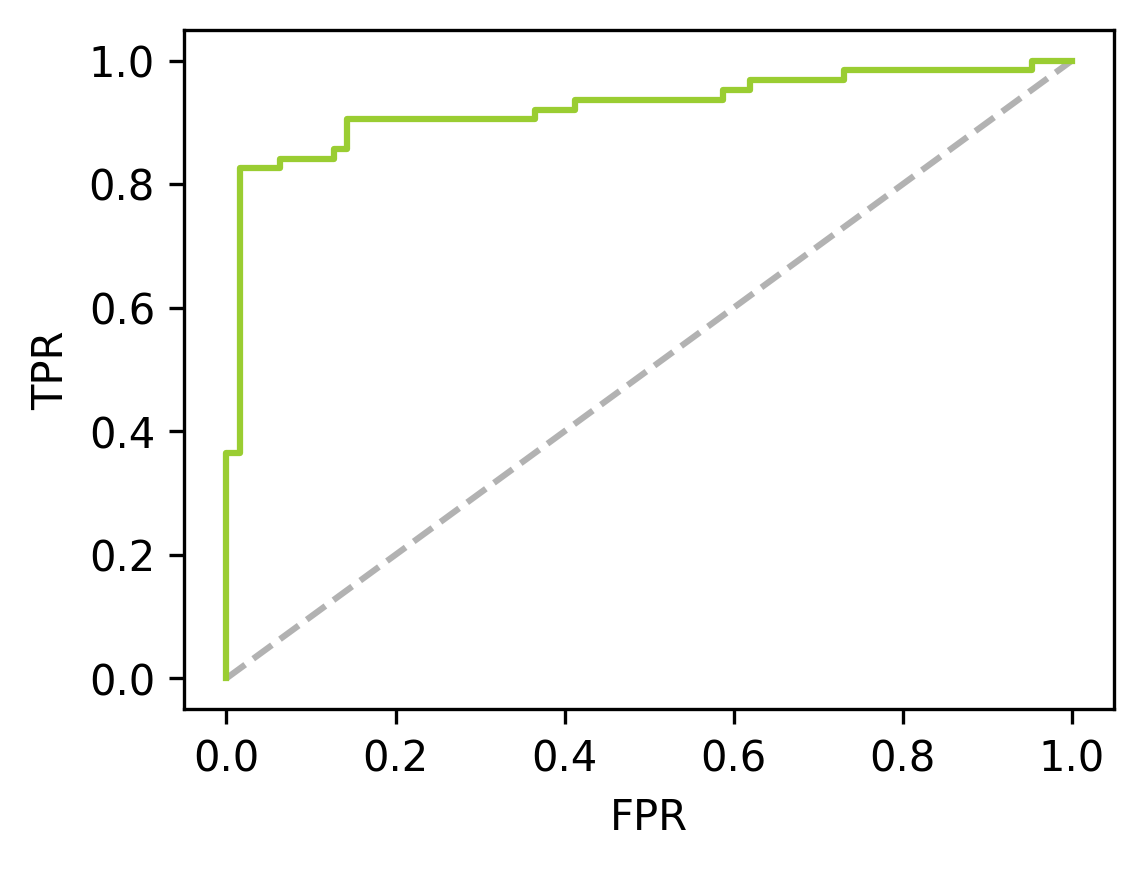

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot((0, 1), (0, 1), linestyle='--', c="gray", alpha=0.6)
ax.plot(fpr, tpr, c='yellowgreen')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.show()

In [ ]:
test_prec, test_recall, _ = precision_recall_curve(test_labels_int, test_predictions)

In [ ]:
test_f1 = f1_score(test_labels_int, test_preds_int)
auprc = auc(test_recall, test_prec)

In [ ]:
for label, val in zip(['F1', 'AUPRC'], [test_f1, auprc]):
  print(f'{label}: {val}')

F1: 0.8571428571428572
AUPRC: 0.9412938050290216


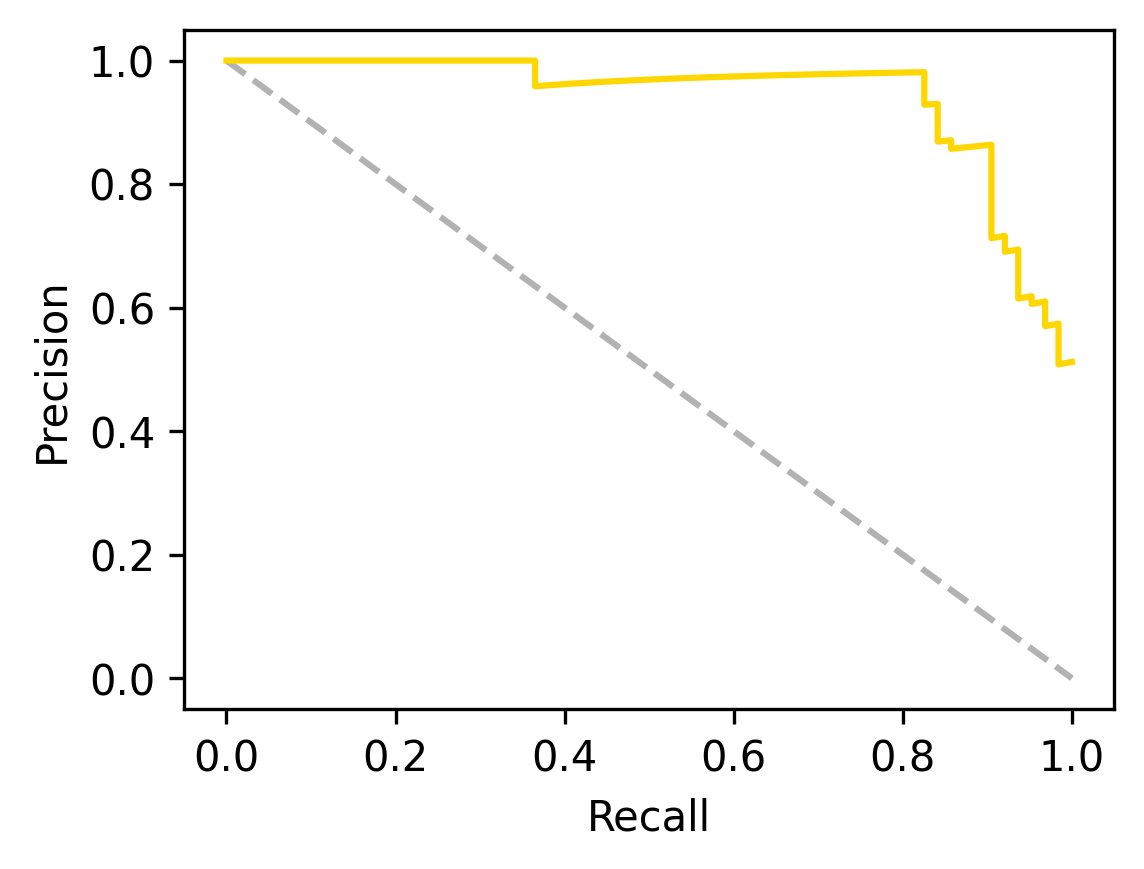

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot((0, 1), (1, 0), linestyle='--', c="gray", alpha=0.6)
ax.plot(test_recall, test_prec, c='gold')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.show()

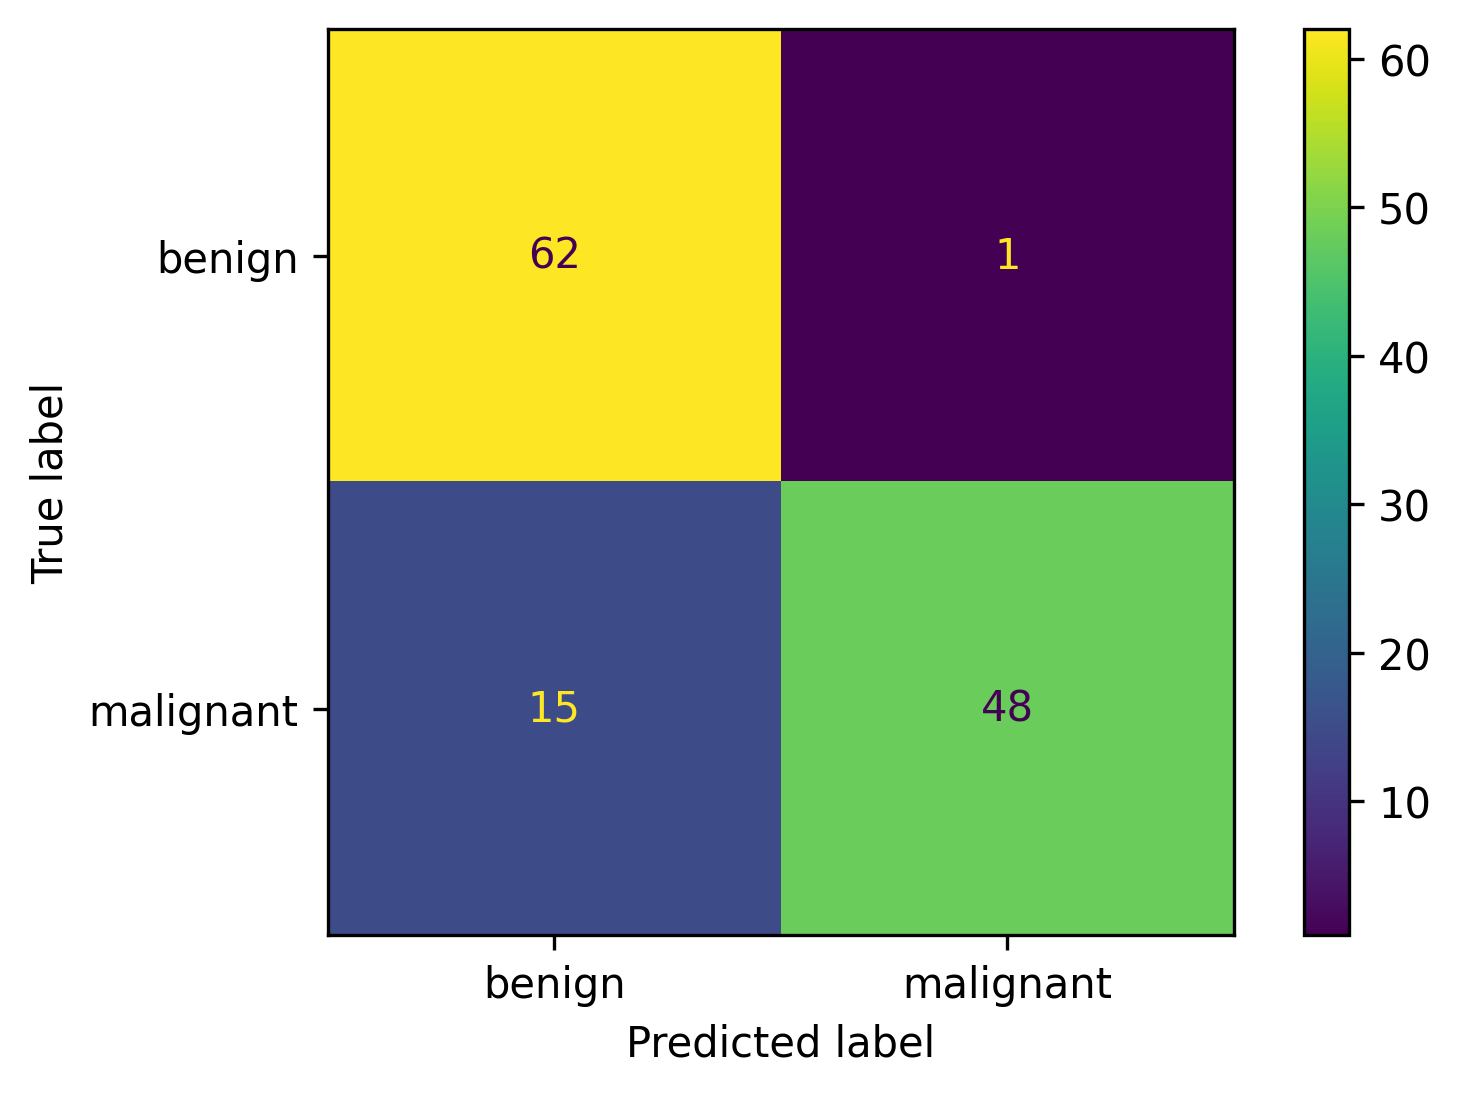

In [ ]:
# Create a confusion matrix
cm = confusion_matrix(test_labels_int, 
                      np.round(test_predictions), 
                      labels=np.unique(test_labels_int))
# Visualize the confusion matrix (use the actual labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=np.unique(test_labels))
# Show the visualization of the confusion matrix
disp.plot()
plt.show()

In [ ]:
true_pos = np.diag(cm)
false_pos = np.sum(cm, axis=0) - true_pos
false_neg = np.sum(cm, axis=1) - true_pos

precision = np.average(true_pos / (true_pos + false_pos))
recall = np.average(true_pos / (true_pos + false_neg))

In [ ]:
print(precision, recall)

0.8923933209647495 0.873015873015873


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


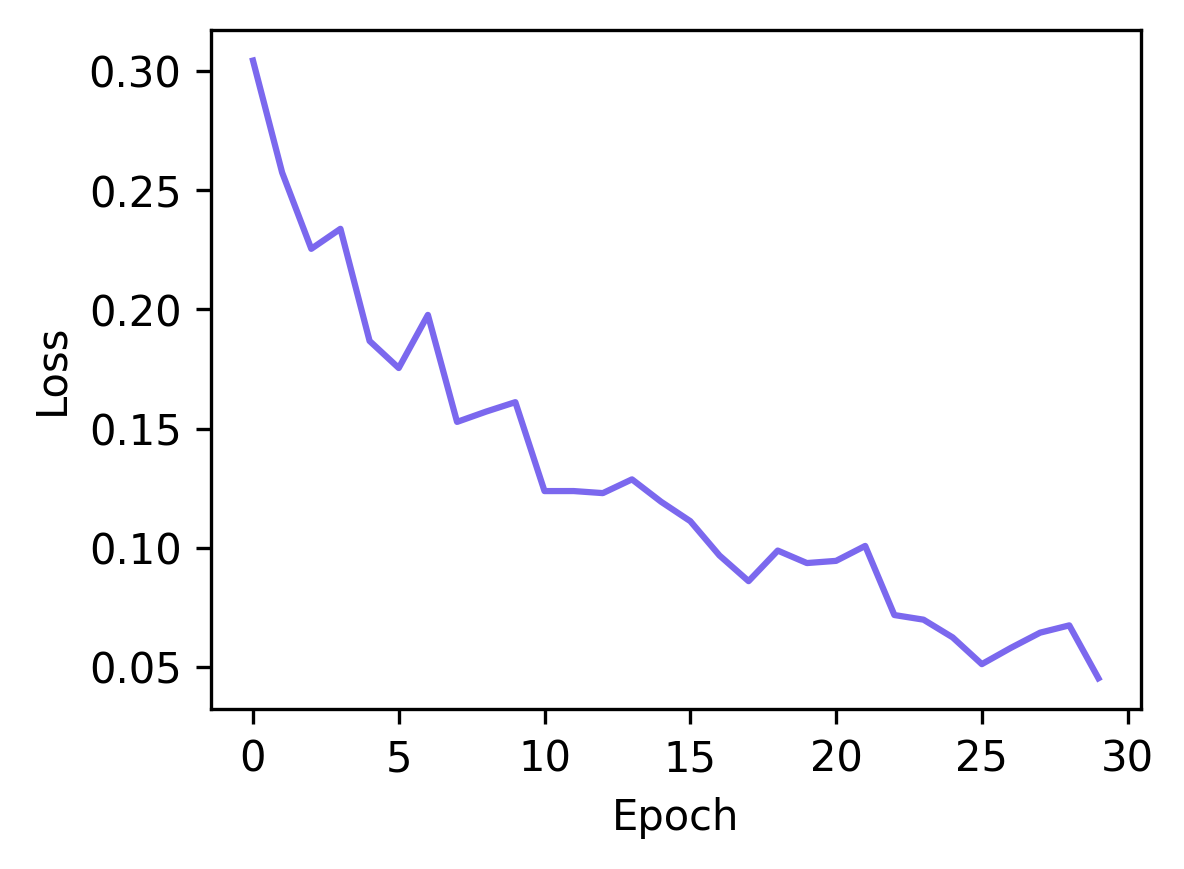

In [ ]:
#
fig, ax = plt.subplots(figsize=(4, 3))
#ax.plot(history.history['val_loss'], c='blue', label="Validation")
ax.plot(history.history['loss'], c='mediumslateblue')#, label="Training")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
#ax.legend(loc='upper right')
plt.show()

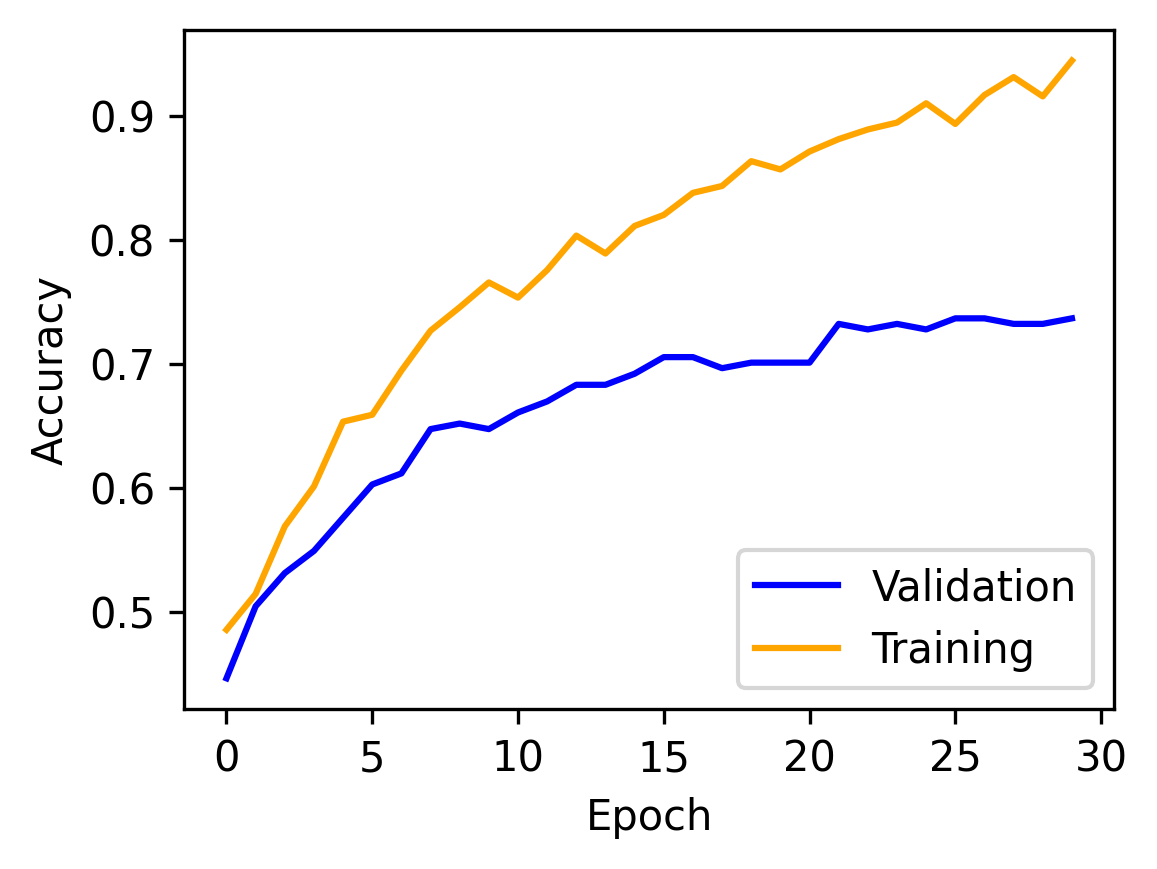

In [ ]:
 #
fig, ax = plt.subplots(figsize=(4, 3))
#ax.plot(history.history['val_accuracy'], c='blue', label="Validation")
ax.plot(history.history['accuracy'], c='orange', label="Training")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower right')
plt.show()

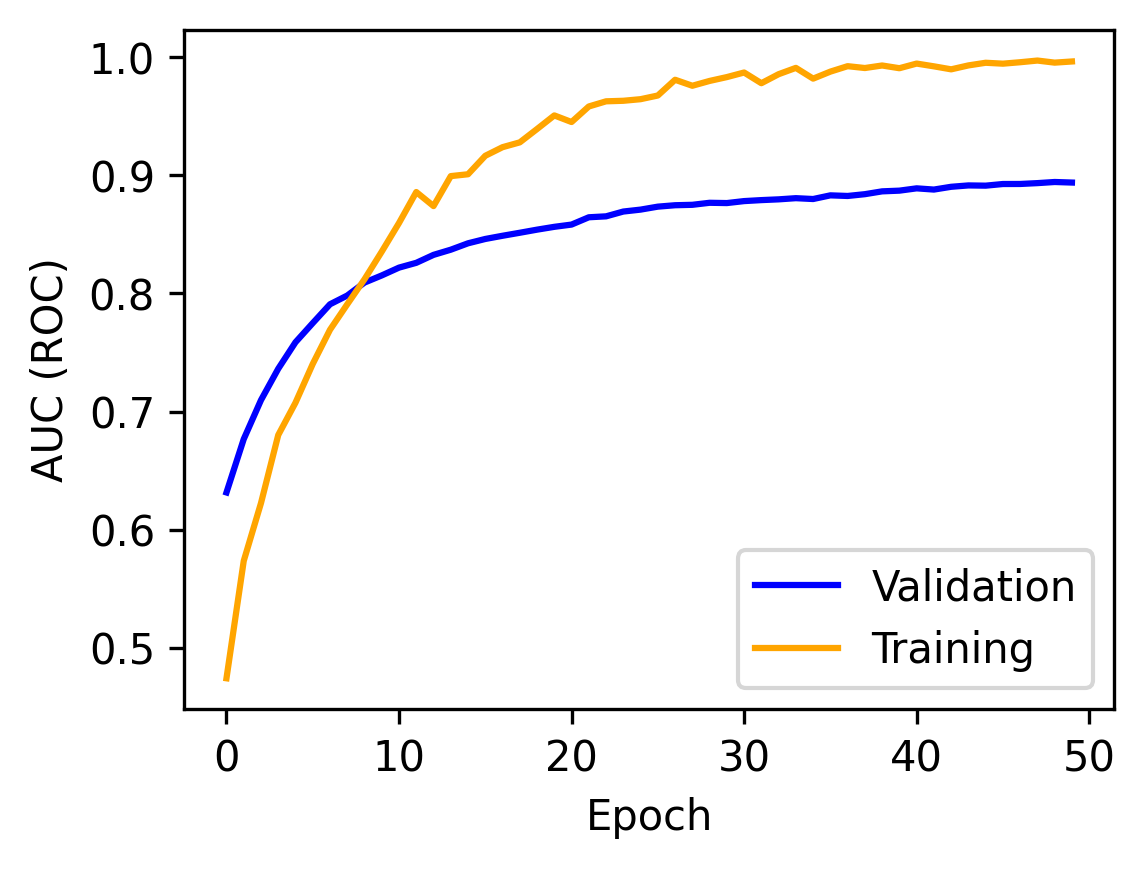

In [ ]:
#
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(history.history['val_auc_4'], c='blue', label="Validation")
ax.plot(history.history['auc_4'], c='orange', label="Training")
ax.set_xlabel('Epoch')
ax.set_ylabel('AUC (ROC)')
ax.legend(loc='lower right')
plt.show()

## Saving model and model history

In [ ]:
# Saving test accuracy to model history
history.history["test_accuracy"] = test_acc

In [ ]:
# Saving model history dict as pickel file
with open('/content/drive/My Drive/REU Colabs/Results/40X_f4.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
# Saving model 
model.save_weights('/content/drive/My Drive/REU Colabs/Results/40X_f4.ckpt')

## Reading in all fold model information

In [ ]:
# Create an empty list in which to store the model history dicts
model_hists = []
# Iterate through and load the dictionaries into the list
for i in range(5):
  with open(f'/content/drive/My Drive/REU Colabs/Results/40X_f{i + 1}.pkl', 'rb') as f:
    model_hists.append(pickle.load(f))

In [ ]:
print(model_hists[0].keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'test_accuracy'])


In [ ]:
master_keys = ['accuracy', 'loss', 'precision', 'recall', 'auc']
training_hist = {k:[] for k in master_keys}
val_hist = {k:[] for k in master_keys}
for model_hist in model_hists:
  for master_key in master_keys:
    for key in model_hist.keys():
      if master_key in key and key != 'test_accuracy':
        if 'val' in key:
          val_hist[master_key].append(model_hist[key])
        elif 'val' not in key:
          training_hist[master_key].append(model_hist[key])

In [ ]:
for k, v in training_hist.items(): print(k, len(v))
print()
for k, v in val_hist.items(): print(k, len(v))

accuracy 5
loss 5
precision 5
recall 5
auc 5

accuracy 5
loss 5
precision 5
recall 5
auc 5


In [ ]:
test_accs = []
for model_hist in model_hists:
  if 'test_acc' in model_hist.keys():
    test_accs.append(model_hist['test_acc'])
  else:
    test_accs.append(model_hist['test_accuracy'])

In [ ]:
training_hist_avg = dict.fromkeys(master_keys)
val_hist_avg = dict.fromkeys(master_keys)

for k, v in training_hist.items():
  training_hist_avg[k] = np.average(np.asarray(v).reshape(30, 5), axis=1)[-1]

for k, v in val_hist.items():
  val_hist_avg[k] = np.average(np.asarray(v).reshape(30, 5), axis=1)[-1]

for d in [training_hist_avg, val_hist_avg]:
  d['f1'] = 2*d['precision']*d['recall']/(d['precision'] + d['recall'])

In [ ]:
for k, v in training_hist_avg.items():
  print(f'{k} final epoch training avg: {v}')
print()
for k, v in val_hist_avg.items():
  print(f'{k} final epoch validation avg: {v}')
print()
print(f'Avg. test accuracy for all 5 fold CV models is {np.average(test_accs)}')

accuracy final epoch training avg: 0.9228888750076294
loss final epoch training avg: 0.1959921509027481
precision final epoch training avg: 0.9238871812820435
recall final epoch training avg: 0.9217777848243713
auc final epoch training avg: 0.9767170071601867
f1 final epoch training avg: 0.9228312776466202

accuracy final epoch validation avg: 0.7214285731315613
loss final epoch validation avg: 0.8190466523170471
precision final epoch validation avg: 0.7297394633293152
recall final epoch validation avg: 0.7035714149475097
auc final epoch validation avg: 0.7989476919174194
f1 final epoch validation avg: 0.7164165632718817

Avg. test accuracy for all 5 fold CV models is 0.807936507936508


In [ ]:
temp_model = create_transfer_vgg_model()
temp_model.load_weights('/content/drive/My Drive/REU Colabs/Results/40X_f5.ckpt')